## 1. Imports

In [21]:
using NNHelferlein

In [22]:
using Knet

In [23]:
using CSV
using DataFrames

In [24]:
using Plots
gr()

Plots.GRBackend()

## 2. Loading and preparing data

In [25]:
trainingdata_pN = "trainingdata_balanced_pN.csv";
validationdata_pN = "validata_pN.csv";

In [26]:
trn_pN = dataframe_read(trainingdata_pN);
val_pN = dataframe_read(validationdata_pN);

Reading data from CSV: trainingdata_balanced_pN.csv
Reading data from CSV: validata_pN.csv


In [27]:
trn_pN_mb_frame = dataframe_minibatches(trn_pN, size=16, ignore=[1], teaching="DiseaseStage", partial=true, shuffle=true)

making minibatches from DataFrame:
... number of records used:  645
... teaching input y is:     DiseaseStage
... number of columns used:  22215
... data columns:            [1007_s_at, 1053_at ... 91920_at, 91952_at]
... number of classes:       3


41-element Knet.Train20.Data{Tuple{CuArray{Float32}, Array{UInt8}}}

In [28]:
val_pN_mb_frame = dataframe_minibatches(val_pN, size=16, ignore=[1], teaching="DiseaseStage", partial=true, shuffle=true)

making minibatches from DataFrame:
... number of records used:  162
... teaching input y is:     DiseaseStage
... number of columns used:  22215
... data columns:            [1007_s_at, 1053_at ... 91920_at, 91952_at]
... number of classes:       3


11-element Knet.Train20.Data{Tuple{CuArray{Float32}, Array{UInt8}}}

In [29]:
x_pN = Array{Float32}(trn_pN[:,3:end])';
trn_pN_mb = minibatch(x_pN,x_pN, 16, shuffle=false,partial=true);

In [30]:
x_pN = Array{Float32}(val_pN[:,3:end])';
val_pN_mb = minibatch(x_pN,x_pN, 16, shuffle=false,partial=true);

## 3. Defining encoder and decoder

### small bottle neck - 8 to 4 neurons

In [31]:
actf = sigm
encoder_diseaseStage = Chain(
    Dense(22215, 512, actf=actf),
    Dense(512, 64, actf=actf),
    Dense(64, 32, actf=actf),
    Dense(32, 8, actf=identity))

decoder_diseaseStage = Chain(
    Dense(4, 16, actf=actf),
    Dense(16, 64, actf=actf),
    Dense(64, 512, actf=actf),
    Dense(512, 22215, actf=identity));

In [32]:
vae_diseaseStage = VAE(encoder_diseaseStage, decoder_diseaseStage); # using encoder and decoder to build vae

In [33]:
print_network(vae_diseaseStage)

NNHelferlein neural network summary:
VAE with 2 layers,                                            22840511 params
Details:
 
    Chain with 4 layers,                                      11409768 params
 
        Dense layer 22215 → 512 with sigm,                    11374592 params
        Dense layer 512 → 64 with sigm,                          32832 params
        Dense layer 64 → 32 with sigm,                            2080 params
        Dense layer 32 → 8 with identity,                          264 params
 
    Chain with 4 layers,                                      11430743 params
 
        Dense layer 4 → 16 with sigm,                               80 params
        Dense layer 16 → 64 with sigm,                            1088 params
        Dense layer 64 → 512 with sigm,                          33280 params
        Dense layer 512 → 22215 with identity,                11396295 params
 
 
Total number of layers: 8
Total number of parameters: 22840511


8

### wide bottle neck - 128 to 64 neurons

In [34]:
actf = relu
encoder_diseaseStage_wide = Chain(
    Dense(22215, 1024, actf=actf),
    Dense(1024, 512, actf=actf),
    Dense(512, 128, actf=actf),
    Dense(128, 128, actf=identity))

decoder_diseaseStage_wide = Chain(
    Dense(64, 128, actf=actf),
    Dense(128, 512, actf=actf),
    Dense(512, 1024, actf=actf),
    Dense(1024, 22215, actf=identity));

In [35]:
vae_diseaseStage_wide = VAE(encoder_diseaseStage_wide, decoder_diseaseStage_wide);

In [36]:
print_network(vae_diseaseStage_wide)

NNHelferlein neural network summary:
VAE with 2 layers,                                            46726215 params
Details:
 
    Chain with 4 layers,                                      23356160 params
 
        Dense layer 22215 → 1024 with relu,                   22749184 params
        Dense layer 1024 → 512 with relu,                       524800 params
        Dense layer 512 → 128 with relu,                         65664 params
        Dense layer 128 → 128 with identity,                     16512 params
 
    Chain with 4 layers,                                      23370055 params
 
        Dense layer 64 → 128 with relu,                           8320 params
        Dense layer 128 → 512 with relu,                         66048 params
        Dense layer 512 → 1024 with relu,                       525312 params
        Dense layer 1024 → 22215 with identity,               22770375 params
 
 
Total number of layers: 8
Total number of parameters: 46726215


8

## 4 Trainig the NNs (VAEs)

In [37]:
vae = tb_train!(vae_diseaseStage, Adam, trn_pN_mb, val_pN_mb, epochs=500,lr_decay=0.00002, lr=0.0002; tb_name="VAE_Disease_Stage", tb_text="VAE",tensorboard=false, return_stats=true);

Training 500 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
TensorBoard logs are disabled!


Progress: 100%|█████████████████████████████████████████| Time: 0:06:288:32


Setting learning rate to η=1.12e-04 in epoch 100.0
Setting learning rate to η=6.32e-05 in epoch 200.0
Setting learning rate to η=3.56e-05 in epoch 300.0
Setting learning rate to η=2.00e-05 in epoch 400.0
Training finished with:
Training loss:       43.14595
Validation loss:     41.16136


In [176]:
writedlm("vae_vld_loss.txt", vae[:loss_vld])
writedlm("vae_trn_loss.txt", vae[:loss_trn])

In [164]:
vae_wide = tb_train!(vae_diseaseStage_wide, Adam, trn_pN_mb, val_pN_mb, epochs=500, lr=0.0002, l2=0.0001, l1=0.00002, tb_name="VAE_Disease_Stage_wide", tb_text="VAE",tensorboard=false, return_stats=true);

Training 500 epochs with 41 minibatches/epoch and 11 validation mbs.
Evaluation is performed every 41 minibatches with 3 mbs.
TensorBoard logs are disabled!


Progress: 100%|█████████████████████████████████████████| Time: 0:07:08


Training finished with:
Training loss:       43.2702
Validation loss:     41.31173


In [177]:
writedlm("vae_wide_vld_loss.txt", vae_wide[:loss_vld])
writedlm("vae_wide_trn_loss.txt", vae_wide[:loss_trn])

## 5 Calculating the heatmap - differences between the classes (stages)

Load the genexpression data separated by the stages

In [165]:
pN0 = "pN0.csv";
pN1 = "pN1.csv";
pN2 = "pN2.csv";

In [166]:
val_pN0 = dataframe_read(pN0);
val_pN1 = dataframe_read(pN1);
val_pN2 = dataframe_read(pN2);

Reading data from CSV: pN0.csv
Reading data from CSV: pN1.csv
Reading data from CSV: pN2.csv


In [167]:
x_pN0 = Array{Float32}(val_pN0[:,4:end])';
val_N0_mb = minibatch(x_pN0,x_pN0, 1, shuffle=false,partial=true);
x_pN1 = Array{Float32}(val_pN1[:,4:end])';
val_N1_mb = minibatch(x_pN1, x_pN1, 1, partial=true);
x_pN2 = Array{Float32}(val_pN2[:,4:end])';
val_N2_mb = minibatch(x_pN2, x_pN2, 1, partial=true);

Functions for calculation:

In [168]:
# data has to be a vector 
# example diStages([mydata])
function divStages(data)
     # prepare data
    all = hcat(data...)
    
    result= [] #CuArray{Float64}(undef, size(all)[2], size(all)[2])
    for p1 in 1:size(all)[2]
        for p2 in 1:size(all)[2]
            push!(result, sum(abs.(all[:,p1] - all[:,p2])))
        end
    end
    result = reshape( result, ( size(all)[2], size(all)[2]))   # heatmap-matrix
    return(result)

end

divStages (generic function with 1 method)

In [169]:
function decodedMb(data; vae)
    decodeddata = []
    for (x,y) in data
        for patient in 1:size(x,2)
            push!(decodeddata, vae(x[:,[patient]]))
        end
    end
    return(hcat(decodeddata...)) # equal to: reduce(hcat,Array(decodeddata))
end

decodedMb (generic function with 1 method)

Calculate the output of the three stages by using the vae with the small bottle neck

In [170]:
N0_mb_decoded = decodedMb(val_N0_mb, vae=vae_diseaseStage)
N1_mb_decoded = decodedMb(val_N1_mb, vae=vae_diseaseStage)
N2_mb_decoded = decodedMb(val_N2_mb, vae=vae_diseaseStage);

In [186]:
# calculate the differences between the stages for all patients
subsetDivstages = divStages([N0_mb_decoded,N1_mb_decoded,N2_mb_decoded]);

In [196]:
writedlm("subsetDivstages_heatmap.txt", subsetDivstages) # save result

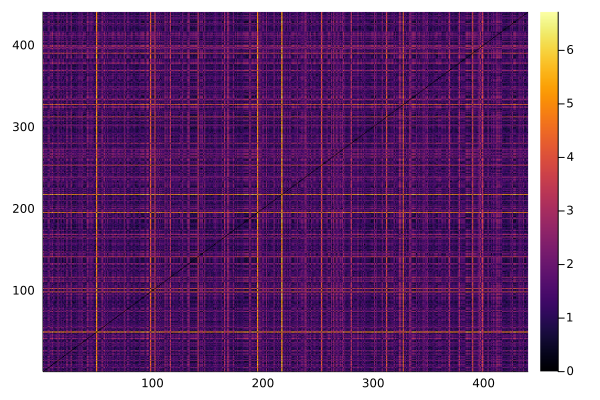

In [195]:
stages_heatmap = heatmap(subsetDivstages) # plot result

Calculate the output of the three stages by using the vae with the wide bottle neck

In [183]:
N0_mb_decoded_wide = decodedMb(val_N0_mb, vae=vae_diseaseStage_wide)
N1_mb_decoded_wide = decodedMb(val_N1_mb, vae=vae_diseaseStage_wide)
N2_mb_decoded_wide = decodedMb(val_N2_mb, vae=vae_diseaseStage_wide);

In [185]:
# calculate the differences between the stages patients
subsetDivstages_wide = divStages([N0_mb_decoded_wide,N1_mb_decoded_wide,N2_mb_decoded_wide]);

In [197]:
writedlm("subsetDivstages_wide_heatmap.txt", subsetDivstages_wide) # save result

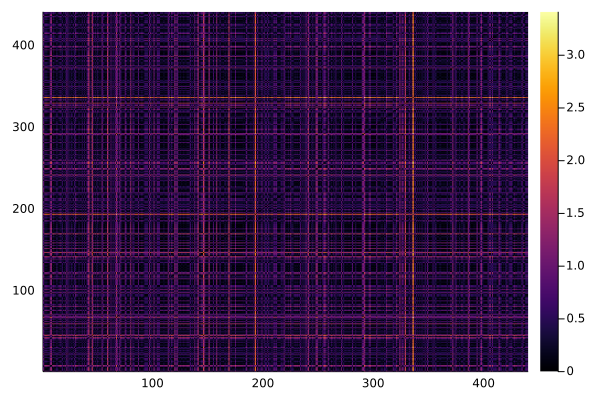

In [187]:
stages_heatmap_wide = heatmap(subsetDivstages_wide) #plot result